In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) # limit gpu memory
    
from psychrnn.tasks.task import Task
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.models.lstm import LSTM
import numpy as np
import pandas as pd
from typing import *
import os
import json
from uuid import UUID
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt

2022-11-16 03:10:15.350636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 03:10:15.448457: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 03:10:15.772787: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib64
2022-11-16 03:10:15.772825: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: 

# just same stuff as before, load the data, define task
### Should move this to a utils module later

In [2]:
teena_data = pd.read_pickle("./teena_df.pickle")
teena_data = teena_data[teena_data["sf"] == True]
teena_data_array = np.dstack(teena_data["traj"])
traj_data = teena_data_array[:2500, :, :100]

In [3]:
class Reach2Grab(Task):
    def __init__(self, dt, tau, T, N_batch):
        super(Reach2Grab, self).__init__(1, 2, dt, tau, T, N_batch)

    def generate_trial_params(self, batch, trial):
        params = dict()
        params["trial_ix"] = np.random.randint(0, traj_data.shape[2])

        return params

    def trial_function(self, time, params):
        x_t = 1 # just a "go" cue
        y_t = traj_data[time, :, params["trial_ix"]]
        
        mask_t = np.ones(shape=y_t.shape, dtype=bool)
        # y_t returns a trajectory

        return x_t, y_t, mask_t

# function to load the model from disk

In [4]:
def load_model(m: str, u: Union[str, UUID]) -> Union[Basic, LSTM]:
    """
    m: one of "Basic" or "LSTM"
    
    u: uuid
    """
    d = Path(f"/home/kushalk/repos/rnn-go-brr/rnngobrr/models/{u}")
    # need to specify extension, these guys are so inconsistent (╯°□°)╯︵ ┻━┻
    weights_path = d.joinpath("weights.npz")
    params_path = d.joinpath("params.json")
    
    params = json.load(open(params_path, "r"))
    params["name"] = str(u)
    params["load_weights_path"] = weights_path
    
    if m == "Basic":
        return Basic(params)
    elif m == "LSTM":
        return LSTM(params)

# Load the dataframe, do not modify the file on disk or we loose last night's run!

In [5]:
df = pd.read_pickle("/home/kushalk/repos/rnn-go-brr/rnngobrr/models_dataframe.pickle")

In [9]:
df

,dt,tau,T,learning_rate,training_iters,N_rec,uuid,arch,task_params
0,1,10,2500,0.0001,100,100,48de2936-2b5f-45cb-9e25-2a05dc033c94,Basic,"{'N_batch': 128, 'N_in': 1, 'N_out': 2, 'dt': ..."
1,1,10,2500,0.0001,100,300,0f136bb3-50c1-4eb2-9759-d3f308737b60,Basic,"{'N_batch': 128, 'N_in': 1, 'N_out': 2, 'dt': ..."
2,1,10,2500,0.0001,100,500,1e5f996a-fac6-481f-8bed-a1a24705f639,Basic,"{'N_batch': 128, 'N_in': 1, 'N_out': 2, 'dt': ..."
3,1,10,2500,0.0001,200,100,ba8e2f75-5733-4675-a2bf-3b9f6fbabb57,Basic,"{'N_batch': 128, 'N_in': 1, 'N_out': 2, 'dt': ..."
4,1,10,2500,0.0001,200,300,dda02b10-efbb-4f91-97de-0648aa349312,Basic,"{'N_batch': 128, 'N_in': 1, 'N_out': 2, 'dt': ..."
...,...,...,...,...,...,...,...,...,...
1075,11,160,2500,0.0,400,300,0820d084-7782-4d5e-9f08-80b0f1b1ee7c,Basic,"{'N_batch': 128, 'N_in': 1, 'N_out': 2, 'dt': ..."
1076,11,160,2500,0.0,400,500,4821d9ca-8b23-45a5-a7e9-e3b700584a4d,Basic,"{'N_batch': 128, 'N_in': 1, 'N_out': 2, 'dt': ..."
1077,11,160,2500,0.0,500,100,00946ae5-e362-4795-90f9-d7bd40e3b53d,Basic,"{'N_batch': 128, 'N_in': 1, 'N_out': 2, 'dt': ..."
1078,11,160,2500,0.0,500,300,1d1b2d61-c2cb-4321-9a29-9211da1db691,Basic,"{'N_batch': 128, 'N_in': 1, 'N_out': 2, 'dt': ..."


In [6]:
ix = 0
row = df.iloc[ix]
model = load_model("Basic", row["uuid"])
task = Reach2Grab(
    dt=row["dt"],
    tau=row["tau"],
    T=row["T"],
    N_batch=128
)

row

dt                                                                1
tau                                                              10
T                                                              2500
learning_rate                                                0.0001
training_iters                                                  100
N_rec                                                           100
uuid                           48de2936-2b5f-45cb-9e25-2a05dc033c94
arch                                                          Basic
task_params       {'N_batch': 128, 'N_in': 1, 'N_out': 2, 'dt': ...
Name: 0, dtype: object

2022-11-16 03:10:46.628510: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 03:10:46.630498: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 03:10:46.630789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 03:10:46.631005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

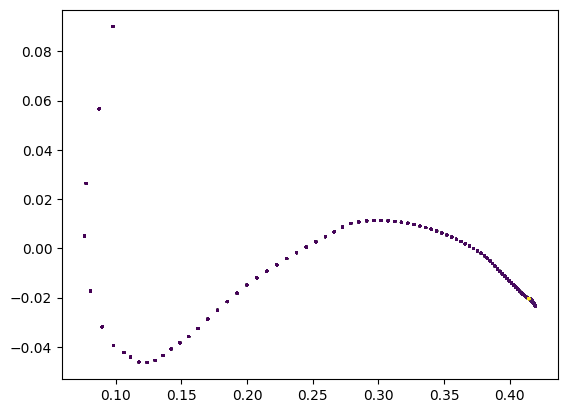

In [8]:
with tf.device('/cpu:0'):
    output, state = model.test(task.get_trial_batch()[0])

for i in range(128):
    plt.scatter(output[i][:, 0], output[i][:, 1], s=1, c=np.arange(output.shape[1]))